In [270]:
from flickplay.mongo import get_mongo_db_obj
from flickplay.get_connections import get_alchemy_con, get_pymysql_con
from flickplay.utils import *
import pandas as pd
con = get_alchemy_con()



In [37]:
u = pd.read_sql("select * from fpa.users;", con)

# Outcome of user after wallet connect event
* describe retention, with/without verified NFT
* retention v.s. # of verified NFTs



# add web3 cohort to users table
* 'wallet_connect_first_datetime'
* web3 cohort w/wo verified NFT
* what are the users doing, who don't have an NFT?
              \ 
             who stay?
             
# most common event among users who stay


In [235]:
con = get_alchemy_con()

query = """
select
    year(lastUsed) last_yr,
    month(lastUsed) last_mo,
    ownsCertifiedNFT,
    count(user_id) churned

from ( select * from fpa.users where (anonymous=0 or anonymous is null) and unclassifiedSignup=0) x

group by 
    last_mo, last_yr, ownsCertifiedNFT

having last_yr < 2023

order by last_yr, last_mo
;
"""

dd = pd.read_sql(query, con)
dd['label'] = [ str(dd.last_yr.iloc[idx])+'-'+str(dd.last_mo.iloc[idx]) for idx, row in \
               dd.iterrows() ]


# with_nft = dd[dd.ownsCertifiedNFT==1]
# no_nft   = dd[dd.ownsCertifiedNFT==0]

# print(dd[['label','churned', 'ownsCertifiedNFT']])

qj = """
select
    year(created) c_yr,
    month(created) c_mo,
    ownsCertifiedNFT,
    count(user_id) joined
    
from ( select * from fpa.users where (anonymous=0 or anonymous is null) and unclassifiedSignup=0) x

group by 
    c_mo, c_yr, ownsCertifiedNFT

having c_yr < 2023

order by c_yr, c_mo

;"""


# qj.replace('c_', 'join_')

# print(qj)
dj = pd.read_sql(qj, con)

dj['label'] = [ str(row.c_yr)+'-'+str(row.c_mo) for i, row in dj.iterrows() ]

djd = dj[['label','joined','ownsCertifiedNFT']]
ddd = dd[['label','churned', 'ownsCertifiedNFT']]
df = djd.merge(ddd)[['label','joined','churned','ownsCertifiedNFT']]
df

,label,joined,churned,ownsCertifiedNFT
0,2020-3,8,2,0
1,2020-4,5,1,0
2,2020-5,26,3,0
3,2020-6,18,12,0
4,2020-7,250,149,0
5,2020-8,138,127,0
6,2020-9,69,73,0
7,2020-10,67,54,0
8,2020-11,60,60,0
9,2020-12,57,62,0


In [622]:
con = get_alchemy_con()


def transform_sql_response(
              data, 
              stringify=True,
              all_columns=False,
              truncate_larger=True,
              backshift=True,
              n_backshift=26):

    d1=data.copy()


    d1['net_change']       =   [ row.joined + row.churned for i, row in d1.iterrows() ]
    d1['cum_joined']       =   [ sum(d1.joined.values[0:i])+d1.iloc[i].joined for i in range(len(d1)) ]
    d1['cum_churned']      =   [ sum(d1.churned.values[0:i])+d1.iloc[i].churned for i in range(len(d1)) ]

    # # backshifting
    # if backshift:
    #     d1['cum_joined']   =   d1['joined']
    #     d1['cum_churned']  =   d1['churned']

    d1['cum_net']          =   [ sum(d1.net_change.values[0:i])+d1.iloc[i].net_change for i in range(len(d1)) ]
    d1['user_pool']        =   d1.cum_joined.values - d1.cum_churned.values
    d1['acqu_month']       =   [ row.joined/(row.user_pool)*100 for i, row in d1.iterrows() ]
    d1['churn_month']      =   [ row.churned/(row.user_pool)*100 for i, row in d1.iterrows() ]
    d1['net_change_pct']   =   d1.net_change / d1.user_pool*100
    d1['net_pct']          =   [ row.net_change/(row.user_pool)*100 for i, row in d1.iterrows() ]
    d1['cum_retention']    =   d1.cum_net/d1.cum_joined*100
    d1['cum_churn']        =   d1.cum_churned/d1.cum_joined*100
    d1['N_joined' ]        =   d1.joined
    d1['N_churned']        =   d1.churned

    if stringify:
        for colname in 	['acqu_month','churn_month','cum_retention','cum_churn','net_change_pct']:
            d1[colname] = d1[colname].apply(lambda x: stringify_pct(x))

    # d1['date'] = d1['label']

    if all_columns:
        return d1

    return d1[['date','ownsCertifiedNFT','joined','churned','net_change',\
               'cum_joined','cum_churned','user_pool',\
               'acqu_month','churn_month','net_change_pct','cum_retention','cum_churn']]

@timer_func
def get_churn_tables(all_columns=False,
                     stringify=True, 
                     truncate_larger=True,
                     backshift_vars=[]):
    
    # the churning query
    query = """
    select
        year(lastUsed) last_yr,
        month(lastUsed) last_mo,
        ownsCertifiedNFT,
        -count(user_id) churned

    from ( select * from fpa.users where (anonymous=0 or anonymous is null) and unclassifiedSignup=0) x

    group by 
        last_mo, last_yr, ownsCertifiedNFT

    having last_yr < 2023

    order by last_yr, last_mo
    ;
    """
    dd = pd.read_sql(query, con)
    dd['date'] = [ str(dd.last_yr.iloc[idx])+'-'+str(dd.last_mo.iloc[idx]) for idx, row in \
                   dd.iterrows() ]


    # users joining flickplay query
    qj = """
    select
        year(created) c_yr,
        month(created) c_mo,
        ownsCertifiedNFT,
        count(user_id) joined

    from ( select * from fpa.users where (anonymous=0 or anonymous is null) and unclassifiedSignup=0) x

    group by 
        c_mo, c_yr, ownsCertifiedNFT

    having c_yr < 2023

    order by c_yr, c_mo

    ;"""
    # dataframe for joined users
    dj = pd.read_sql(qj, con)
    dj['date'] = [ str(row.c_yr)+'-'+str(row.c_mo) for i, row in dj.iterrows() ]
    djd = dj[['date','joined','ownsCertifiedNFT']]
    ddd = dd[['date','churned', 'ownsCertifiedNFT']]
    df = djd.merge(ddd)[['date','joined','churned','ownsCertifiedNFT']]

    def stringify_pct(pct):
        if type(pct) == float:
            return '+'+str(round(pct,2))+'%' if pct>=0 else str(round(pct,2))+'%'
        else:
            return pct

    d1 = df[df.ownsCertifiedNFT==1]
    d0 = df[df.ownsCertifiedNFT==0]

    data_out = [d0,d1]
    
    
    output_transforms = [ 
                # lambda x: transform_sql_response(x, all_columns=1, stringify=stringify),
                lambda x: transform_sql_response(x, all_columns=False, stringify=stringify),
                # lambda x: x+100 if type(x) == int else x
                
        ]
        
    def apply_transforms(data,output_transforms=output_transforms):
        for tr in output_transforms:
            data = list(map(tr, data))
        return data
        
    return apply_transforms(data_out,output_transforms=output_transforms)

d00,d11 = get_churn_tables()


Function 'get_churn_tables' executed in 0.1760s


In [623]:
get_churn_tables()[1]

Function 'get_churn_tables' executed in 0.1776s


,date,ownsCertifiedNFT,joined,churned,net_change,cum_joined,cum_churned,user_pool,acqu_month,churn_month,net_change_pct,cum_retention,cum_churn
27,2022-5,1,7,-1,6,7,-1,8,+87.5%,-12.5%,+75.0%,+85.71%,-14.29%
29,2022-6,1,33,-2,31,40,-3,43,+76.74%,-4.65%,+72.09%,+92.5%,-7.5%
31,2022-7,1,156,-83,73,196,-86,282,+55.32%,-29.43%,+25.89%,+56.12%,-43.88%
33,2022-8,1,12,-21,-9,208,-107,315,+3.81%,-6.67%,-2.86%,+48.56%,-51.44%
35,2022-9,1,38,-48,-10,246,-155,401,+9.48%,-11.97%,-2.49%,+36.99%,-63.01%
37,2022-10,1,12,-23,-11,258,-178,436,+2.75%,-5.28%,-2.52%,+31.01%,-68.99%
39,2022-11,1,9,-24,-15,267,-202,469,+1.92%,-5.12%,-3.2%,+24.34%,-75.66%
41,2022-12,1,16,-34,-18,283,-236,519,+3.08%,-6.55%,-3.47%,+16.61%,-83.39%


In [633]:
d00.columns

Index(['date', 'ownsCertifiedNFT', 'joined', 'churned', 'net_change',
       'cum_joined', 'cum_churned', 'user_pool', 'acqu_month', 'churn_month',
       'net_change_pct', 'cum_retention', 'cum_churn'],
      dtype='object')

In [546]:
d11.columns

Index(['date', 'ownsCertifiedNFT', 'N_joined', 'N_churned', 'net_change',
       'cum_joined', 'cum_churned', 'user_pool', 'acqu_month', 'churn_month',
       'net_change_pct', 'cum_retention', 'cum_churn'],
      dtype='object')

kinds: ['usersWithCertifiedNFT', 'usersWithoutCerfifiedNFT']
bardata[usersWithCertifiedNFT][date]: ['2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']
bardata[usersWithCertifiedNFT][cum_retention]: [0.8571, 0.925, 0.5612, 0.4856, 0.3699, 0.3101, 0.2434, 0.1661]
bardata[usersWithoutCerfifiedNFT][date]: ['2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3', '2022-4', '2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']
bardata[usersWithoutCerfifiedNFT][cum_retention]: [0.75, 0.7692, 0.8462, 0.6842, 0.456, 0.3393, 0.286, 0.2754, 0.2496, 0.2221, 0.2228, 0.228, 0.2421, 0.236, 0.2236, 0.2204, 0.2082, 0.2023, 0.211, 0.206, 0.1951, 0.3204, 0.3415, 0.3355, 0.3299, 0.318, 0.2938, 0.2562, 0.2077, 0.1634, 0.1344, 0.1013, 0.1452, 0.1174]
h

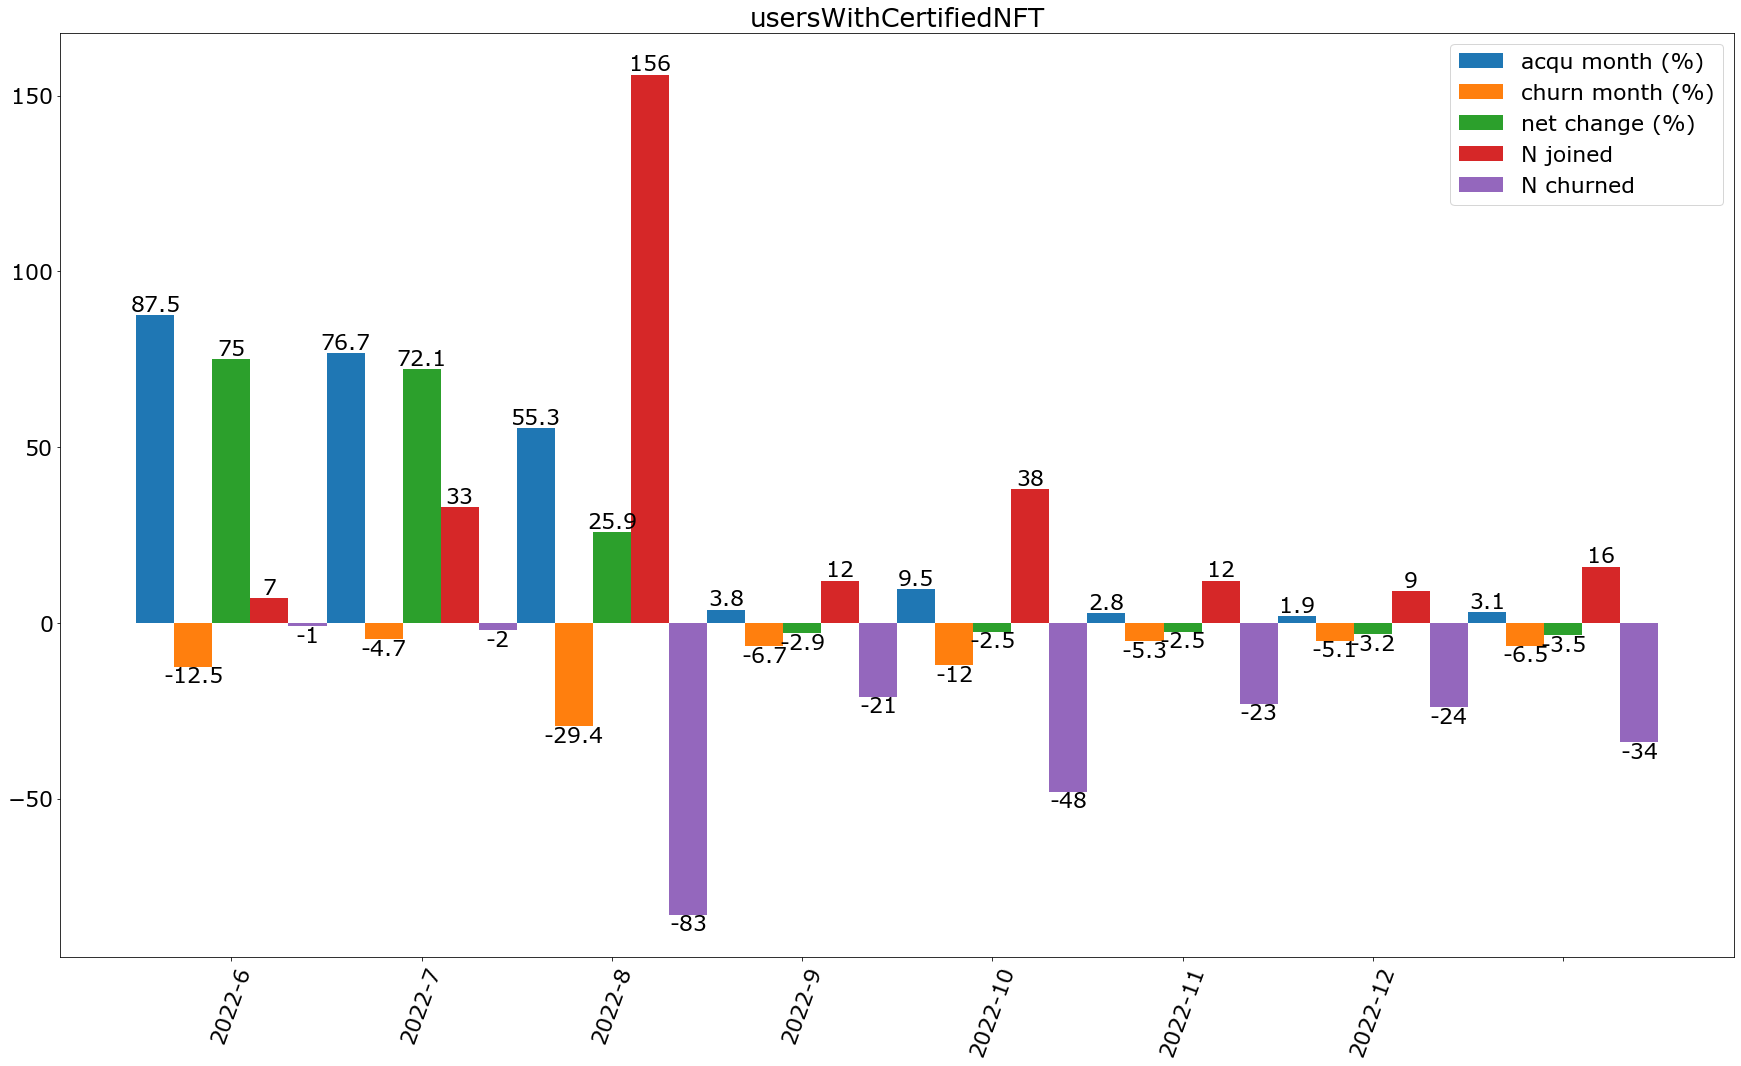

hey!!!
5
0.18000000000000002 [-2, -1, 0, 1, 2]
5
0.2 [-2, -1, 0, 1, 2]
N vars:	['acqu_month', 'churn_month', 'net_change_pct', 'joined', 'churned']
bar_ax_objects[usersWithoutCerfifiedNFT][acqu_month] = ax.bar(pos+0.2*-2, barY, 0.2, label=f'acqu month (%)')
bar_ax_objects[usersWithoutCerfifiedNFT][churn_month] = ax.bar(pos+0.2*-1, barY, 0.2, label=f'churn month (%)')
bar_ax_objects[usersWithoutCerfifiedNFT][net_change_pct] = ax.bar(pos+0.2*0, barY, 0.2, label=f'net change (%)')
bar_ax_objects[usersWithoutCerfifiedNFT][joined] = ax.bar(pos+0.2*1, barY, 0.2, label=f'N joined')
bar_ax_objects[usersWithoutCerfifiedNFT][churned] = ax.bar(pos+0.2*2, barY, 0.2, label=f'N churned')


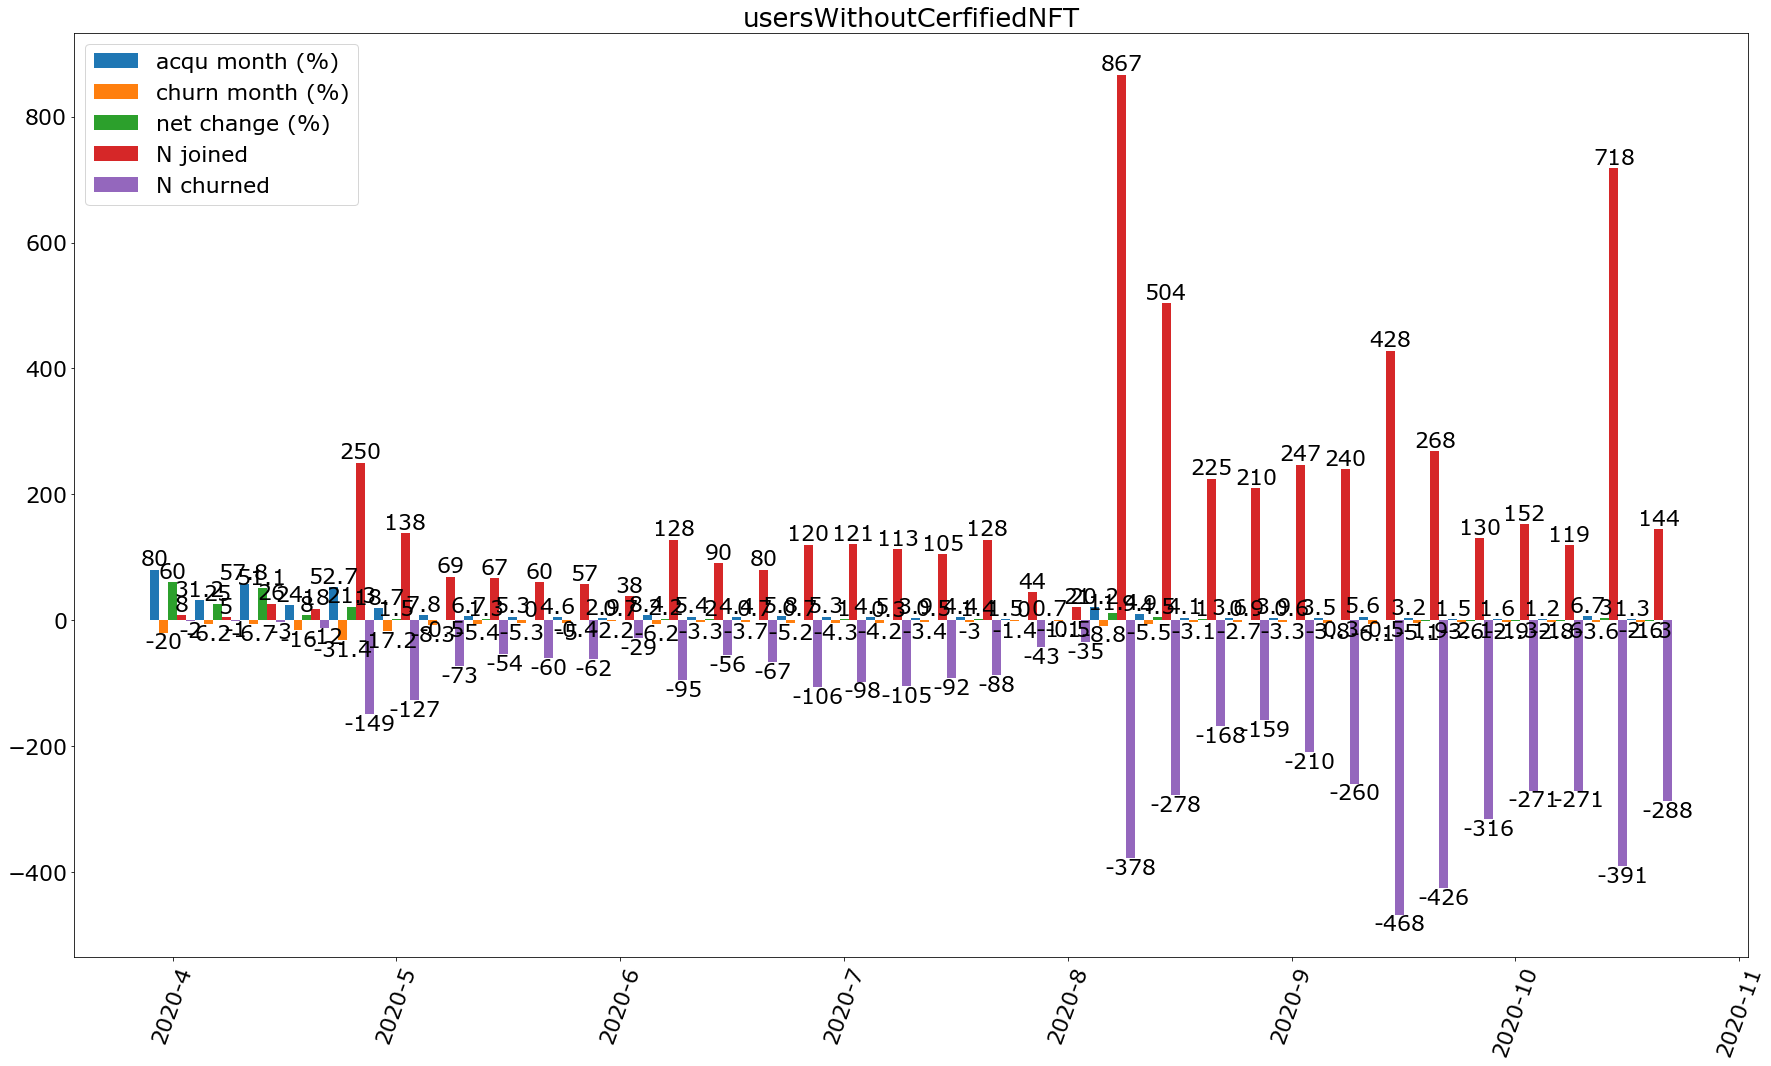

kinds: ['usersWithCertifiedNFT', 'usersWithoutCerfifiedNFT']
bardata[usersWithCertifiedNFT][date]: ['2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']
bardata[usersWithCertifiedNFT][cum_retention]: [0.8571, 0.925, 0.5612, 0.4856, 0.3699, 0.3101, 0.2434, 0.1661]
bardata[usersWithoutCerfifiedNFT][date]: ['2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3', '2022-4', '2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']
bardata[usersWithoutCerfifiedNFT][cum_retention]: [0.75, 0.7692, 0.8462, 0.6842, 0.456, 0.3393, 0.286, 0.2754, 0.2496, 0.2221, 0.2228, 0.228, 0.2421, 0.236, 0.2236, 0.2204, 0.2082, 0.2023, 0.211, 0.206, 0.1951, 0.3204, 0.3415, 0.3355, 0.3299, 0.318, 0.2938, 0.2562, 0.2077, 0.1634, 0.1344, 0.1013, 0.1452, 0.1174]
h

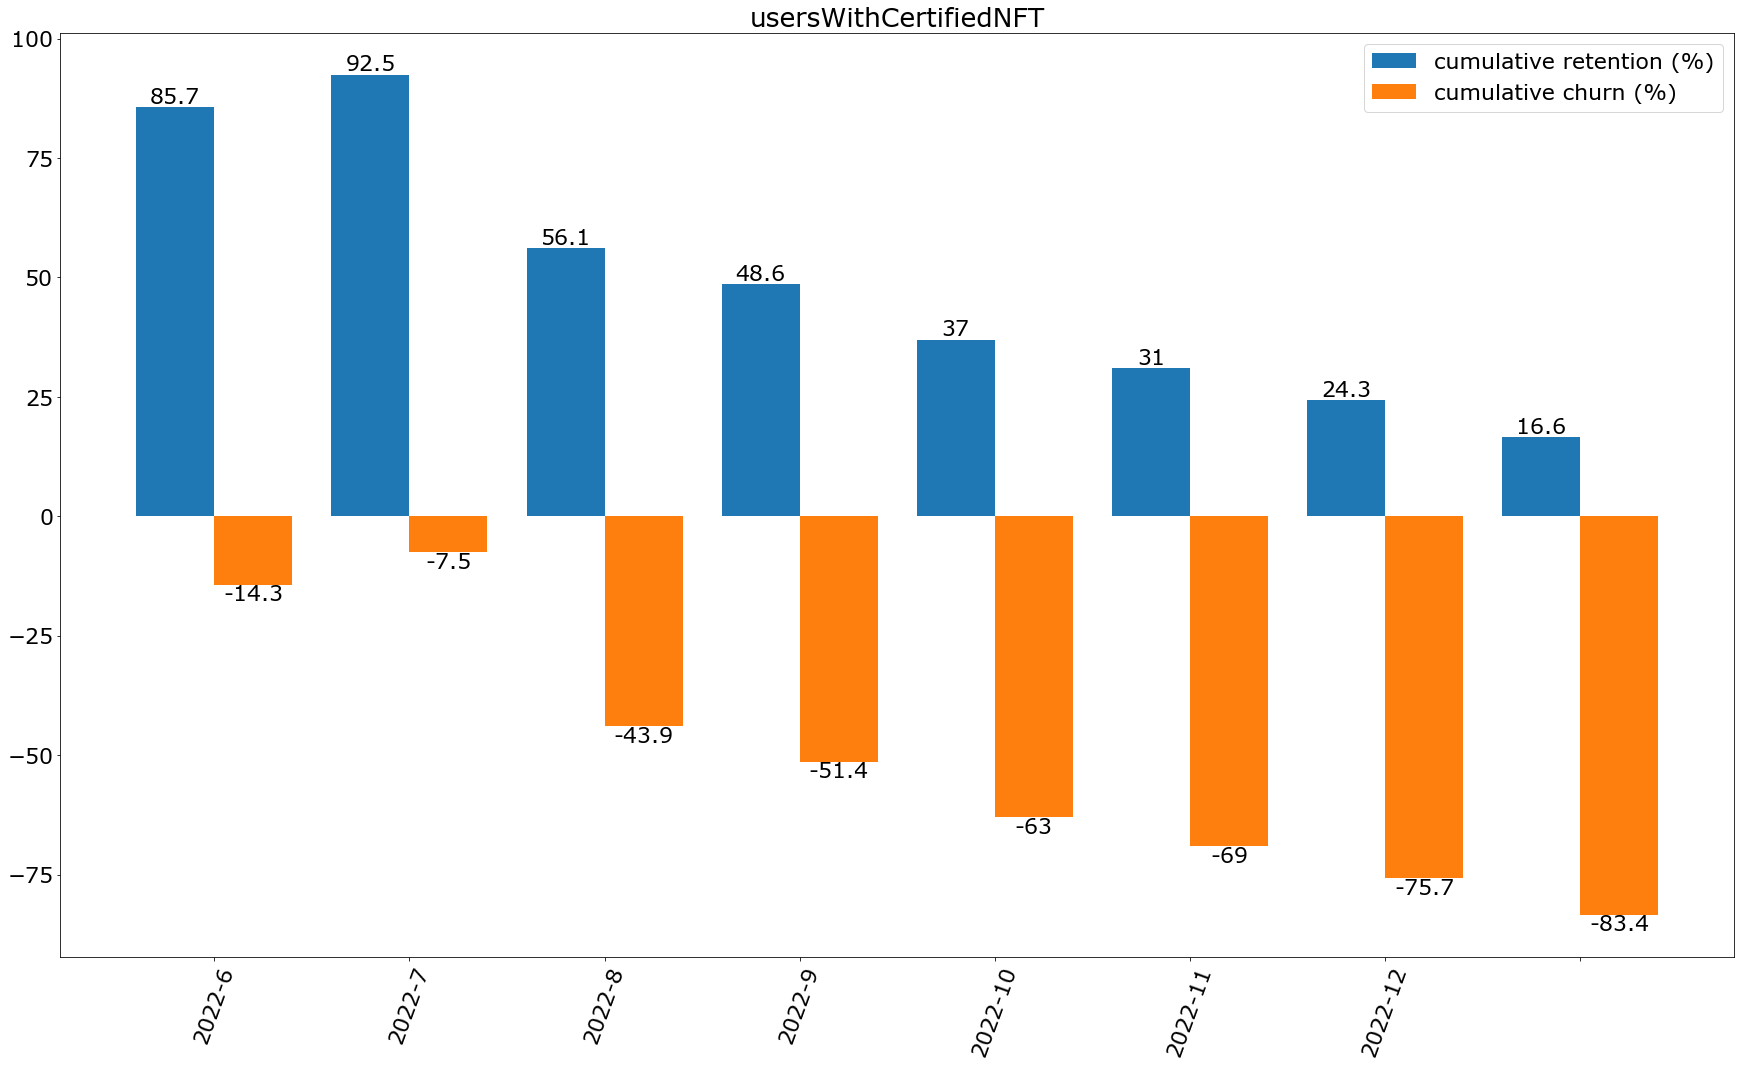

hey!!!
2
Goodbye, 0!!!!!
2
0.4 [-0.5  0.5]
N vars:	['cum_retention', 'cum_churn']
bar_ax_objects[usersWithoutCerfifiedNFT][cum_retention] = ax.bar(pos+0.4*-0.5, barY, 0.4, label=f'cumulative retention (%)')
bar_ax_objects[usersWithoutCerfifiedNFT][cum_churn] = ax.bar(pos+0.4*0.5, barY, 0.4, label=f'cumulative churn (%)')


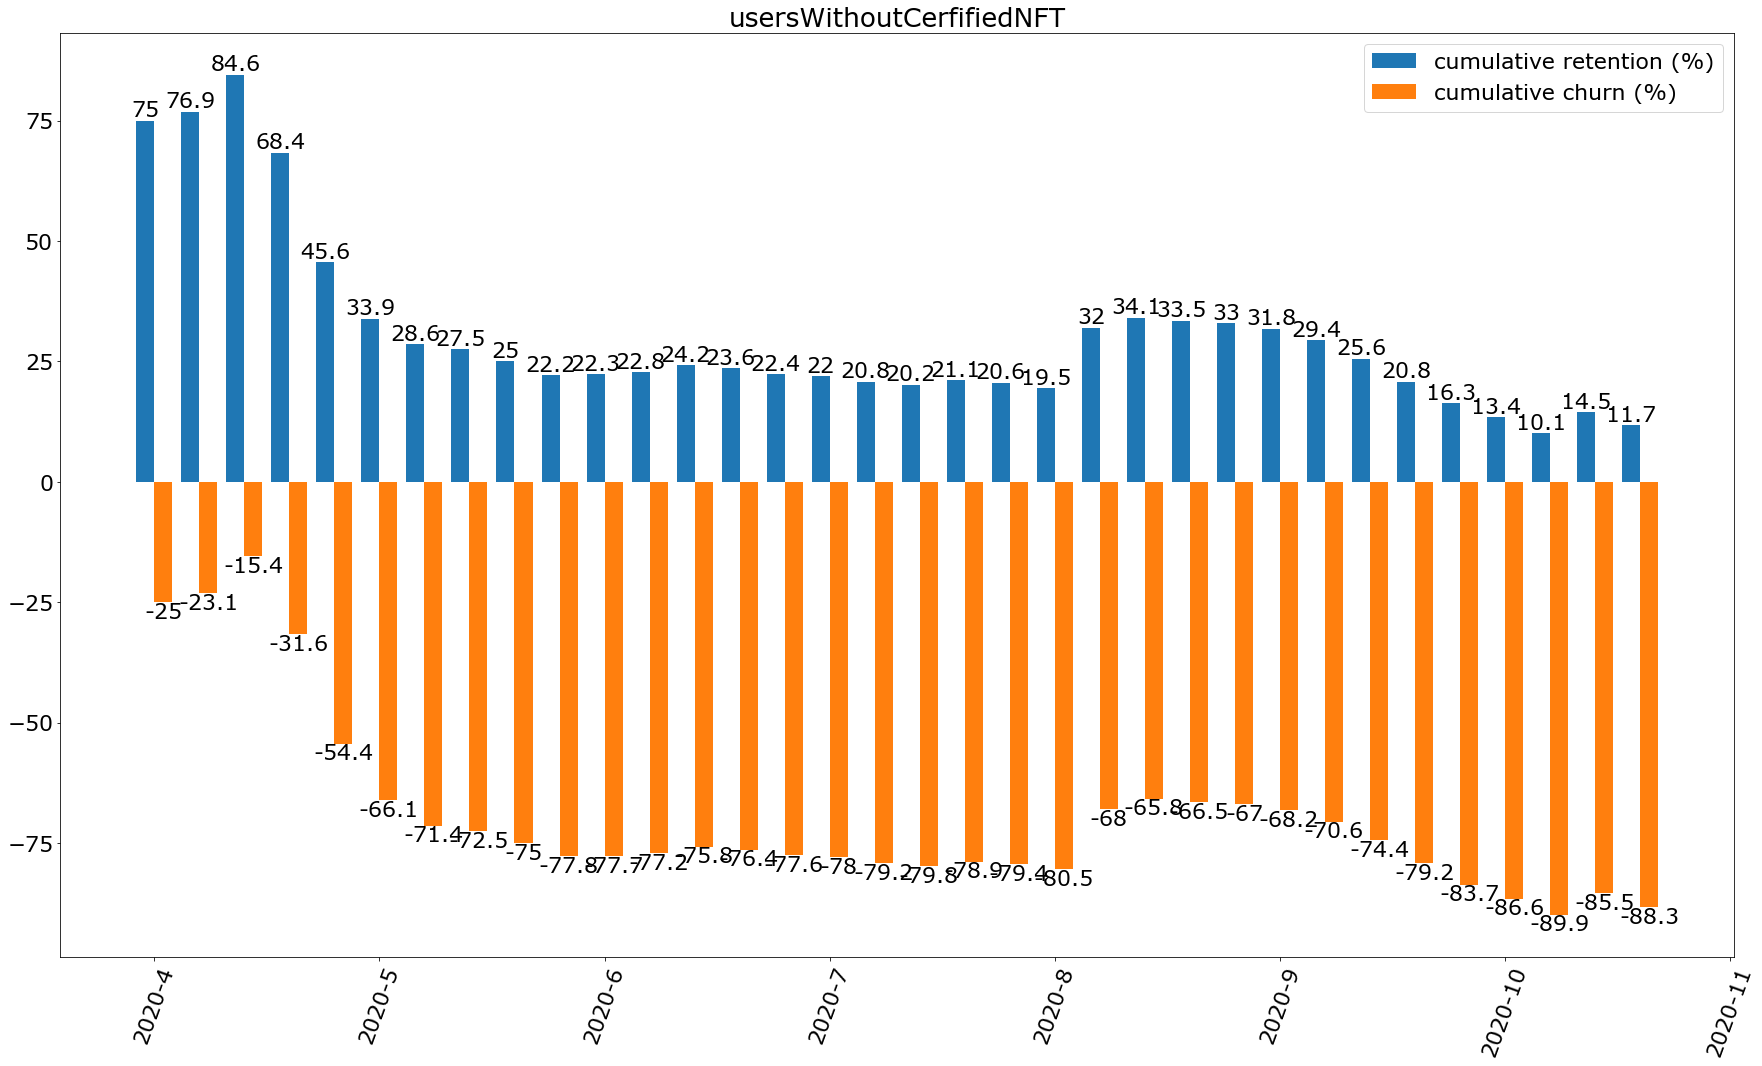

In [636]:
import numpy as np



def plotify(kinds=None, columns_to_barplot=None):
    
    def unstringify_pct(spct):
        if type(spct)==str:
            return round(float(spct.replace('+','').replace('%','')),6)
        else:
            return spct


    def barify_data(data: pd.DataFrame,
                    truncate=False)-> dict:
        data = data[['date']+list(data.columns[2:])]
        
        cum_cols = [
            
            ]
        return { k: list(map(unstringify_pct, v.values())) if k!='date' else list(v.values()) for k, v in data.to_dict().items() }

    dataframes = {
        'usersWithCertifiedNFT': d11,
        'usersWithoutCerfifiedNFT': d00
        }
    kinds = list(sorted(dataframes.keys()))
    print('kinds:', kinds)

    bardata = { k: barify_data(v, truncate=1) for k,v in dataframes.items() }
    for kind in kinds:
        for col in ['date','cum_retention']:
            print(f'bardata[{kind}][{col}]:', bar_data[kind][col])



    if columns_to_barplot is None:
        columns_to_barplot = [
        'cum_retention', 'cum_churn', 'net_change_pct'
        ]
    if kinds is None:
        kinds = ['usersWithCertifiedNFT']


    for kind in kinds:

        fig, ax = make_big(f=22,w=30,h=17)
        bar_ax_objects = { kind: dict() for kind in kinds }



        def get_bar_shifts(nbars):
            x=nbars
            width = 1/x-1/2*1/x**2
            vec = []
            idx = -(x//2)
            while idx <= abs(x//2):
                vec.append(idx)
                idx+=1
            if x%2==0:
                vec.remove(0)
                print('Goodbye, 0!!!!!')

                return width, np.array(vec)/2
                print(width, vec)

            print(width, vec)
            return width, vec

        VERBOSE=True
        print('hey!!!')
        VERBOSE and print(len(columns_to_barplot))
        # print(bar_width)
        bar_width, bar_shifts = get_bar_shifts(len(columns_to_barplot))
        bar_width = round(bar_width,1)

        VERBOSE and print(len(columns_to_barplot)) 
        VERBOSE and print(bar_width, bar_shifts)
        VERBOSE and print(f'N vars:\t{columns_to_barplot}')



        for i, col in enumerate(columns_to_barplot):
                barY   = bardata[kind][col]
                labels = bardata[kind]['date']
                pos = np.arange(len(labels))
                shift = bar_shifts[i]

                collabel = col
                # there labels which are a percentage
                pcts = [ 'acqu_month', 'churn_month','net_change_pct', 'cum_retention', 'cum_churn']
                endchar = ''
                start_char = 'N '
                if collabel in pcts:
                    endchar+=' (%)'
                    start_char=''
                if col.startswith('cum'):
                    collabel = col.replace('cum_','cumulative_')
                collabel = collabel.replace('_',' ').strip()
                collabel = collabel.replace('pct','').strip()
                collabel = start_char + collabel 
                collabel += endchar
                

                ff = f'''bar_ax_objects[{kind}][{col}] = ax.bar(pos+{bar_width}*{shift}, barY, {bar_width}, label=f'{collabel}')'''
                VERBOSE and print(ff)

                cols = ','.join(columns_to_barplot)
                title = f'''{kind}'''
                ax.set_title(title)
                ax.set_xticklabels(labels)

                axis_obj = ax.bar(pos+bar_width*shift, list(map(lambda x: round(x, 1), barY)) , bar_width,label=f'{collabel}')
                bar_ax_objects[kind][col] = axis_obj
                ax.bar_label(axis_obj)

                # plt.ylabel('%')
                plt.xticks(rotation=70)


        plt.legend()        
        plt.show()

plotify(
        kinds=['usersWithoutCerfifiedNFT', 'usersWithCertifiedNFT'], 
        columns_to_barplot=['acqu_month',
                            'churn_month','net_change_pct', 'joined','churned',
                            #'cum_retention',
                            #'cum_churn'])
                           ])
plotify(
        kinds=['usersWithoutCerfifiedNFT', 'usersWithCertifiedNFT'], 
        columns_to_barplot=[#'acqu_month',
                            #'churn_month','net_change_pct',
                            'cum_retention',
                            'cum_churn'#])
                           ])

kinds: ['usersWithCertifiedNFT', 'usersWithoutCerfifiedNFT']
bardata[usersWithCertifiedNFT][date]: ['2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']
bardata[usersWithCertifiedNFT][cum_retention]: [0.8571, 0.925, 0.5612, 0.4856, 0.3699, 0.3101, 0.2434, 0.1661]
bardata[usersWithoutCerfifiedNFT][date]: ['2020-3', '2020-4', '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9', '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3', '2022-4', '2022-5', '2022-6', '2022-7', '2022-8', '2022-9', '2022-10', '2022-11', '2022-12']
bardata[usersWithoutCerfifiedNFT][cum_retention]: [0.75, 0.7692, 0.8462, 0.6842, 0.456, 0.3393, 0.286, 0.2754, 0.2496, 0.2221, 0.2228, 0.228, 0.2421, 0.236, 0.2236, 0.2204, 0.2082, 0.2023, 0.211, 0.206, 0.1951, 0.3204, 0.3415, 0.3355, 0.3299, 0.318, 0.2938, 0.2562, 0.2077, 0.1634, 0.1344, 0.1013, 0.1452, 0.1174]
h

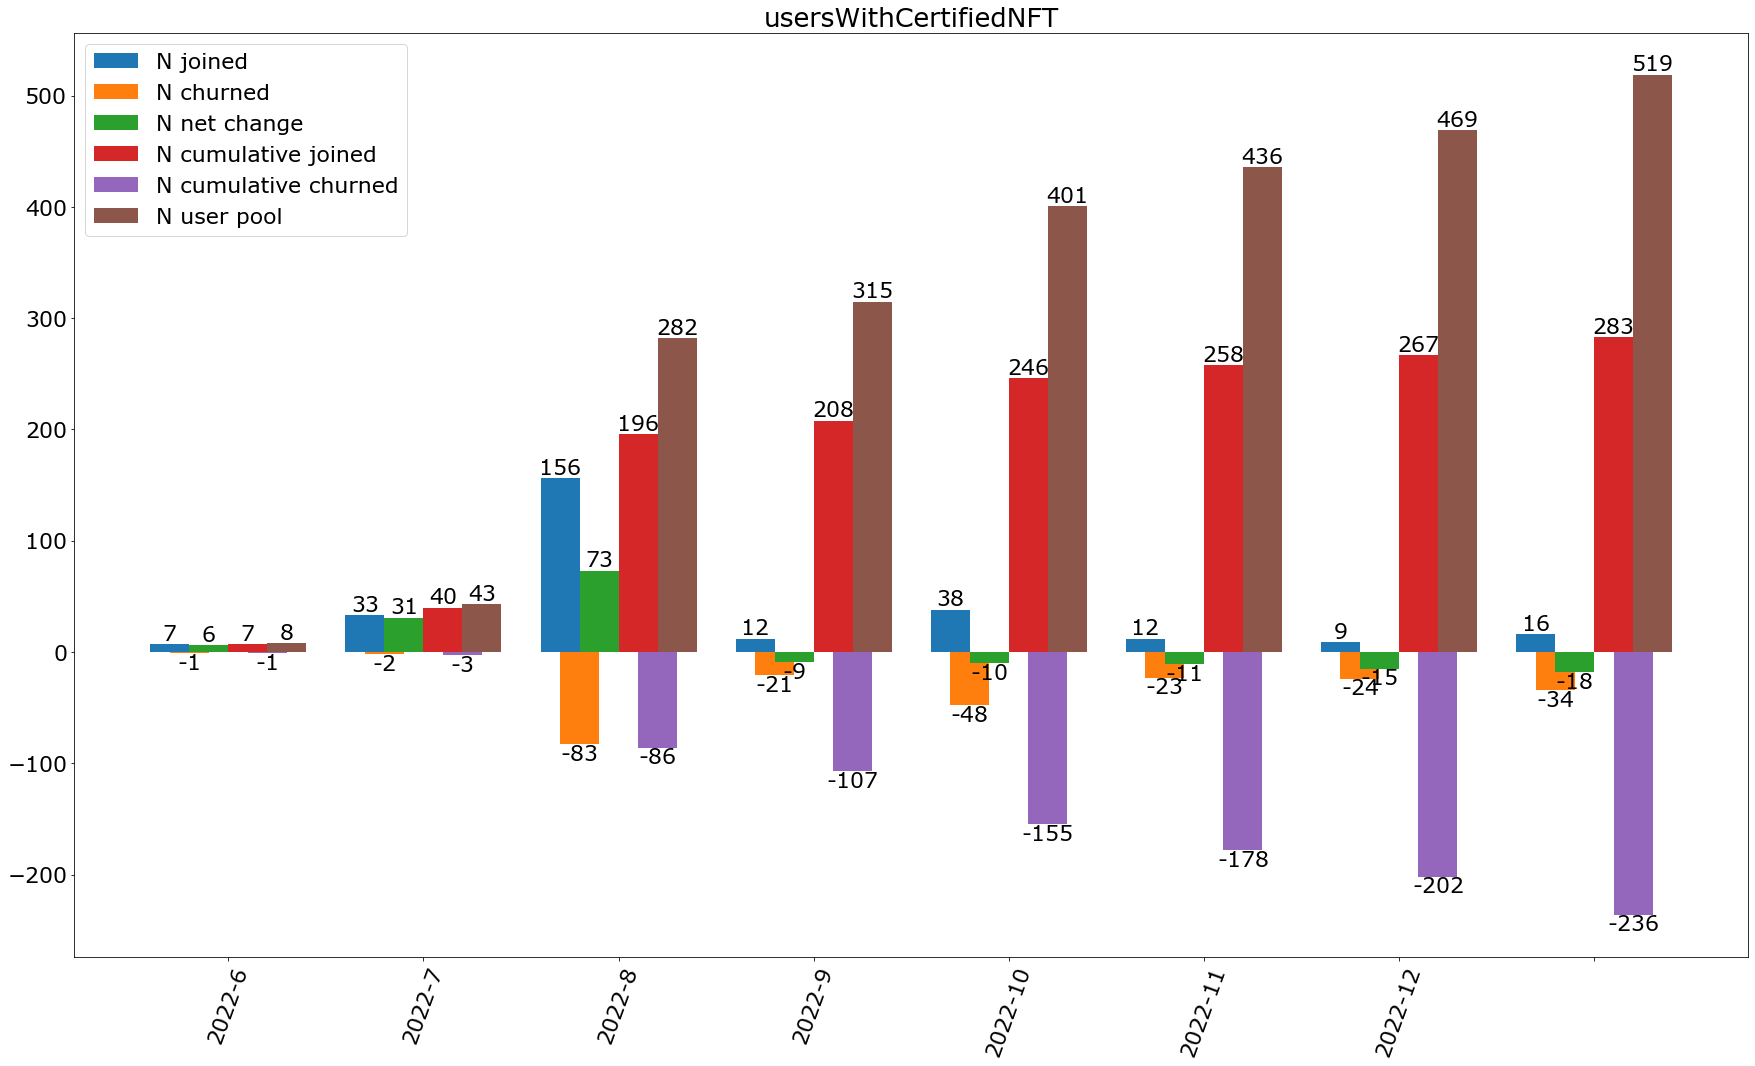

hey!!!
6
Goodbye, 0!!!!!
6
0.2 [-1.5 -1.  -0.5  0.5  1.   1.5]
N vars:	['joined', 'churned', 'net_change', 'cum_joined', 'cum_churned', 'user_pool']
bar_ax_objects[usersWithoutCerfifiedNFT][joined] = ax.bar(pos+0.2*-1.5, barY, 0.2, label=f'N joined')
bar_ax_objects[usersWithoutCerfifiedNFT][churned] = ax.bar(pos+0.2*-1.0, barY, 0.2, label=f'N churned')
bar_ax_objects[usersWithoutCerfifiedNFT][net_change] = ax.bar(pos+0.2*-0.5, barY, 0.2, label=f'N net change')
bar_ax_objects[usersWithoutCerfifiedNFT][cum_joined] = ax.bar(pos+0.2*0.5, barY, 0.2, label=f'N cumulative joined')
bar_ax_objects[usersWithoutCerfifiedNFT][cum_churned] = ax.bar(pos+0.2*1.0, barY, 0.2, label=f'N cumulative churned')
bar_ax_objects[usersWithoutCerfifiedNFT][user_pool] = ax.bar(pos+0.2*1.5, barY, 0.2, label=f'N user pool')


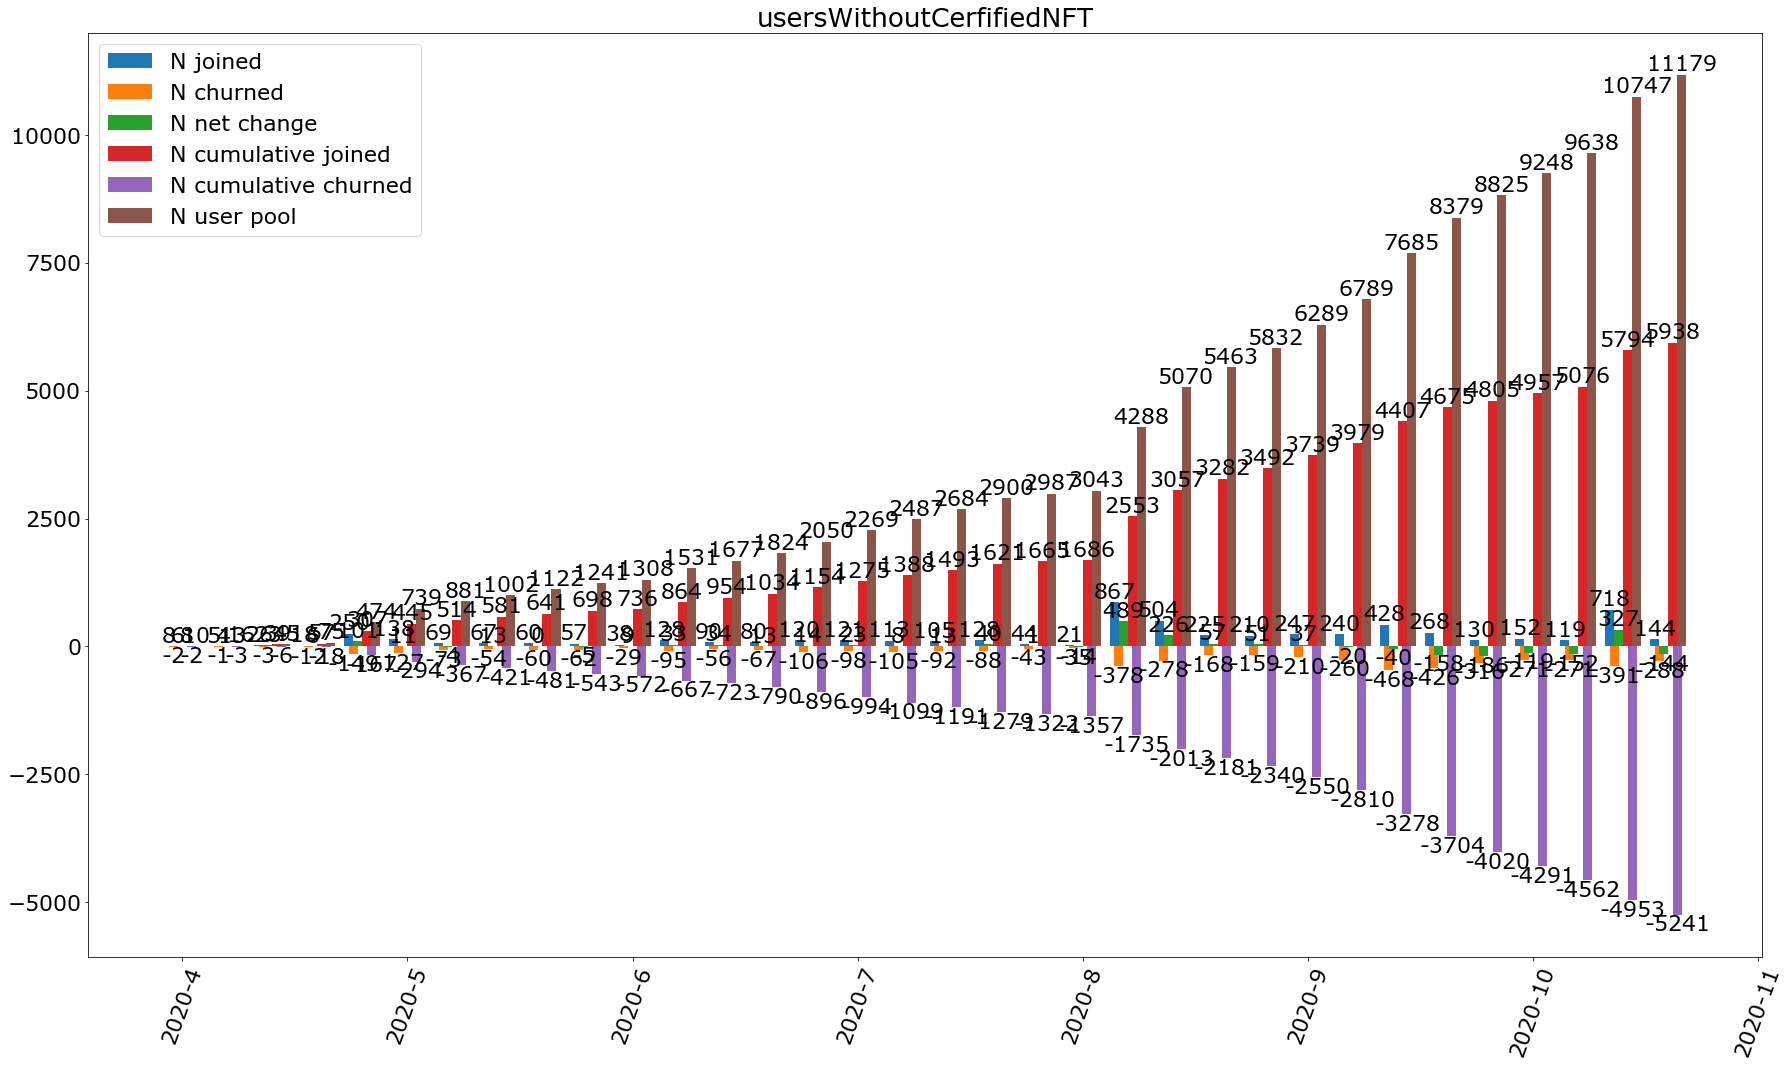

In [637]:
plotify(columns_to_barplot=['joined', 'churned', 'net_change',
       'cum_joined', 'cum_churned', 'user_pool'])

In [485]:
plotify(
        kinds=['usersWithoutCerfifiedNFT', 'usersWithCertifiedNFT'], 
        columns_to_barplot=['acqu_month',
                            'churn_month','net_change_pct',
                            'cum_retention',
                            'cum_churn'])


,date,ownsCertifiedNFT,joined,churned,net_change,cum_joined,cum_churned,user_pool,net_change_pct,cum_retention,cum_churn
27,2022-5,1,7,1,6,7,1,6,+100.0%,+85.71%,+14.29%
29,2022-6,1,33,2,31,40,3,37,+83.78%,+92.5%,+7.5%
31,2022-7,1,156,83,73,196,86,110,+66.36%,+56.12%,+43.88%
33,2022-8,1,12,21,-9,208,107,101,-8.91%,+48.56%,+51.44%
35,2022-9,1,38,48,-10,246,155,91,-10.99%,+36.99%,+63.01%
37,2022-10,1,12,23,-11,258,178,80,-13.75%,+31.01%,+68.99%
39,2022-11,1,9,24,-15,267,202,65,-23.08%,+24.34%,+75.66%
41,2022-12,1,16,34,-18,283,236,47,-38.3%,+16.61%,+83.39%


In [449]:
get_bar_shifts(4)[1]

[-0.05078125, -0.025390625, 0.025390625, 0.05078125]

In [427]:
f(1) = [0]
f(2) = [-1,1]
f(3) = [-1,0,1]
f(5) = [-2,-1,0,1,2]

SyntaxError: cannot assign to function call (1894592316.py, line 1)

In [345]:
# -5//2

-3

In [412]:

def get_bar_positions(nbars):
    x=nbars
    width = (0.4 + 0.1/x**2)*(1/x)
    vec = []
    idx = -(x//2)
    while idx <= abs(x//2):
        vec.append(idx)
        idx+=1
    if x%2==0:
        vec.remove(0)
    return width,vec
    
w,v = get_bar_positions(5)
    
    


In [419]:
import random
x = random.randint(1,10)
w,v = get_bar_positions(x)

print(x,w,v)

2 0.21250000000000002 [-1, 1]


In [357]:
# barify_data(d00, truncate=1)

In [317]:
{k: v[26:] for k,v in barify_data(d00).items()}

{'date': ['2022-5',
  '2022-6',
  '2022-7',
  '2022-8',
  '2022-9',
  '2022-10',
  '2022-11',
  '2022-12'],
 'joined': [240, 428, 268, 130, 152, 119, 718, 144],
 'churned': [260, 468, 426, 316, 271, 271, 391, 288],
 'net_change': [-20, -40, -158, -186, -119, -152, 327, -144],
 'cum_joined': [3979, 4407, 4675, 4805, 4957, 5076, 5794, 5938],
 'cum_churned': [2810, 3278, 3704, 4020, 4291, 4562, 4953, 5241],
 'user_pool': [1169, 1129, 971, 785, 666, 514, 841, 697],
 'net_change_pct': [-0.0171,
  -0.0354,
  -0.1627,
  -0.2369,
  -0.1787,
  -0.2957,
  0.3888,
  -0.2066],
 'cum_retention': [0.2938,
  0.2562,
  0.2077,
  0.1634,
  0.1344,
  0.1013,
  0.1452,
  0.1174],
 'cum_churn': [0.7062, 0.7438, 0.7923, 0.8366, 0.8656, 0.8987, 0.8548, 0.8826]}

In [316]:
barify_data(d11)

{'date': ['2022-5',
  '2022-6',
  '2022-7',
  '2022-8',
  '2022-9',
  '2022-10',
  '2022-11',
  '2022-12'],
 'joined': [7, 33, 156, 12, 38, 12, 9, 16],
 'churned': [1, 2, 83, 21, 48, 23, 24, 34],
 'net_change': [6, 31, 73, -9, -10, -11, -15, -18],
 'cum_joined': [7, 40, 196, 208, 246, 258, 267, 283],
 'cum_churned': [1, 3, 86, 107, 155, 178, 202, 236],
 'user_pool': [6, 37, 110, 101, 91, 80, 65, 47],
 'net_change_pct': [1.0,
  0.8378,
  0.6636,
  -0.0891,
  -0.1099,
  -0.1375,
  -0.2308,
  -0.383],
 'cum_retention': [0.8571,
  0.925,
  0.5612,
  0.4856,
  0.3699,
  0.3101,
  0.2434,
  0.1661],
 'cum_churn': [0.1429, 0.075, 0.4388, 0.5144, 0.6301, 0.6899, 0.7566, 0.8339]}

In [309]:
# bar_data['users

In [310]:
# dataframes


{'usersWithCertifiedNFT':        date  ownsCertifiedNFT  joined  churned  net_change  cum_joined  \
 27   2022-5                 1       7        1           6           7   
 29   2022-6                 1      33        2          31          40   
 31   2022-7                 1     156       83          73         196   
 33   2022-8                 1      12       21          -9         208   
 35   2022-9                 1      38       48         -10         246   
 37  2022-10                 1      12       23         -11         258   
 39  2022-11                 1       9       24         -15         267   
 41  2022-12                 1      16       34         -18         283   
 
     cum_churned  user_pool net_change_pct cum_retention cum_churn  
 27            1          6        +100.0%       +85.71%   +14.29%  
 29            3         37        +83.78%        +92.5%     +7.5%  
 31           86        110        +66.36%       +56.12%   +43.88%  
 33          107      

In [303]:
dataframes['usersWithCertifiedNFT']

,date,ownsCertifiedNFT,joined,churned,net_change,cum_joined,cum_churned,user_pool,net_change_pct,cum_retention,cum_churn
0,2020-3,0,8,2,6,8,2,6,+100.0%,+75.0%,+25.0%
1,2020-4,0,5,1,4,13,3,10,+40.0%,+76.92%,+23.08%
2,2020-5,0,26,3,23,39,6,33,+69.7%,+84.62%,+15.38%
3,2020-6,0,18,12,6,57,18,39,+15.38%,+68.42%,+31.58%
4,2020-7,0,250,149,101,307,167,140,+72.14%,+45.6%,+54.4%
5,2020-8,0,138,127,11,445,294,151,+7.28%,+33.93%,+66.07%
6,2020-9,0,69,73,-4,514,367,147,-2.72%,+28.6%,+71.4%
7,2020-10,0,67,54,13,581,421,160,+8.12%,+27.54%,+72.46%
8,2020-11,0,60,60,0,641,481,160,+0.0%,+24.96%,+75.04%
9,2020-12,0,57,62,-5,698,543,155,-3.23%,+22.21%,+77.79%


In [233]:
# df = djd.merge(ddd)[['label','net_joined','net_churned','ownsCertifiedNFT']]

# import seaborn as sns



In [234]:
# import matplotlib.pyplot as plt
# import matplotlib
# import matplotlib.dates as mdates

# font = {'family' : 'verdana',
#        # 'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(18.5, 10.5)


# df

In [226]:

# d11.net_change_pct.apply(lambda x : unstringify_pct(x))/100


AttributeError: 'Series' object has no attribute 'number_joined'

In [193]:
d11.cum_churned/sum(d11.cum_net)
d11['number_joined'] - d11['number_churned']

27     6
29    31
31    73
33    -9
35   -10
37   -11
39   -15
41   -18
dtype: int64

In [198]:
# d00.net_change/d00.user_pool

27    0.142857
29    0.075000
31    0.438776
33    0.514423
35    0.630081
37    0.689922
39    0.756554
41    0.833922
dtype: float64

In [196]:
d11

,label,number_joined,number_churned,ownsCertifiedNFT,net_change,cum_joined,cum_churned,cum_net,user_pool,net_change_pct,join_pct,churn_pct,net_pct,cum_retention
27,2022-5,7,1,1,6,7,1,6,6,+100.0%,+116.67%,+16.67%,+100.0%,+85.71%
29,2022-6,33,2,1,31,40,3,37,37,+83.78%,+89.19%,+5.41%,+83.78%,+92.5%
31,2022-7,156,83,1,73,196,86,110,110,+66.36%,+141.82%,+75.45%,+66.36%,+56.12%
33,2022-8,12,21,1,-9,208,107,101,101,-8.91%,+11.88%,+20.79%,-8.91%,+48.56%
35,2022-9,38,48,1,-10,246,155,91,91,-10.99%,+41.76%,+52.75%,-10.99%,+36.99%
37,2022-10,12,23,1,-11,258,178,80,80,-13.75%,+15.0%,+28.75%,-13.75%,+31.01%
39,2022-11,9,24,1,-15,267,202,65,65,-23.08%,+13.85%,+36.92%,-23.08%,+24.34%
41,2022-12,16,34,1,-18,283,236,47,47,-38.3%,+34.04%,+72.34%,-38.3%,+16.61%


In [182]:
d00=add_fracs(d0)
d00

,label,number_joined,number_churned,ownsCertifiedNFT,net_change,cum_joined,cum_churned,cum_net,user_pool,net_change_pct,join_pct,churn_pct,net_pct,cum_retention
0,2020-3,8,2,0,6,8,2,6,6,+100.0%,+100.0%,+100.0%,+100.0%,+100.0%
1,2020-4,5,1,0,4,13,3,10,10,+40.0%,+40.0%,+40.0%,+40.0%,+40.0%
2,2020-5,26,3,0,23,39,6,33,33,+69.7%,+69.7%,+69.7%,+69.7%,+69.7%
3,2020-6,18,12,0,6,57,18,39,39,+15.38%,+15.38%,+15.38%,+15.38%,+15.38%
4,2020-7,250,149,0,101,307,167,140,140,+72.14%,+72.14%,+72.14%,+72.14%,+72.14%
5,2020-8,138,127,0,11,445,294,151,151,+7.28%,+7.28%,+7.28%,+7.28%,+7.28%
6,2020-9,69,73,0,-4,514,367,147,147,-2.72%,-2.72%,-2.72%,-2.72%,-2.72%
7,2020-10,67,54,0,13,581,421,160,160,+8.12%,+8.12%,+8.12%,+8.12%,+8.12%
8,2020-11,60,60,0,0,641,481,160,160,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%
9,2020-12,57,62,0,-5,698,543,155,155,-3.23%,-3.23%,-3.23%,-3.23%,-3.23%


In [178]:
d11

,label,number_joined,number_churned,ownsCertifiedNFT,net_change,cum_joined,cum_churned,cum_net,user_pool,net_change_pct,join_pct,churn_pct,net_pct,cum_retention
27,2022-5,7,1,1,6,7,1,6,6,+100.0%,+100.0%,+100.0%,+100.0%,+100.0%
29,2022-6,33,2,1,31,40,3,37,37,+83.78%,+83.78%,+83.78%,+83.78%,+83.78%
31,2022-7,156,83,1,73,196,86,110,110,+66.36%,+66.36%,+66.36%,+66.36%,+66.36%
33,2022-8,12,21,1,-9,208,107,101,101,-8.91%,-8.91%,-8.91%,-8.91%,-8.91%
35,2022-9,38,48,1,-10,246,155,91,91,-10.99%,-10.99%,-10.99%,-10.99%,-10.99%
37,2022-10,12,23,1,-11,258,178,80,80,-13.75%,-13.75%,-13.75%,-13.75%,-13.75%
39,2022-11,9,24,1,-15,267,202,65,65,-23.08%,-23.08%,-23.08%,-23.08%,-23.08%
41,2022-12,16,34,1,-18,283,236,47,47,-38.3%,-38.3%,-38.3%,-38.3%,-38.3%


In [179]:
d00[['label','

,label,number_joined,number_churned,ownsCertifiedNFT,net_change,cum_joined,cum_churned,cum_net,user_pool,net_change_pct,join_pct,churn_pct,net_pct,cum_retention
0,2020-3,8,2,0,6,8,2,6,6,+100.0%,+100.0%,+100.0%,+100.0%,+100.0%
1,2020-4,5,1,0,4,13,3,10,10,+40.0%,+40.0%,+40.0%,+40.0%,+40.0%
2,2020-5,26,3,0,23,39,6,33,33,+69.7%,+69.7%,+69.7%,+69.7%,+69.7%
3,2020-6,18,12,0,6,57,18,39,39,+15.38%,+15.38%,+15.38%,+15.38%,+15.38%
4,2020-7,250,149,0,101,307,167,140,140,+72.14%,+72.14%,+72.14%,+72.14%,+72.14%
5,2020-8,138,127,0,11,445,294,151,151,+7.28%,+7.28%,+7.28%,+7.28%,+7.28%
6,2020-9,69,73,0,-4,514,367,147,147,-2.72%,-2.72%,-2.72%,-2.72%,-2.72%
7,2020-10,67,54,0,13,581,421,160,160,+8.12%,+8.12%,+8.12%,+8.12%,+8.12%
8,2020-11,60,60,0,0,641,481,160,160,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%
9,2020-12,57,62,0,-5,698,543,155,155,-3.23%,-3.23%,-3.23%,-3.23%,-3.23%


In [162]:
d11.net_change_pct.apply(lambda x: '+'+str(x)+'%' if x>=0 else str(x)+'%')

27    +100.0%
29    +83.78%
31    +66.36%
33     -8.91%
35    -10.99%
37    -13.75%
39    -23.08%
41     -38.3%
Name: net_change_pct, dtype: object

In [141]:
d11.columns

Index(['label', 'number_joined', 'number_churned', 'ownsCertifiedNFT',
       'net_change', 'cum_joined', 'cum_churned', 'cum_net', 'user_pool',
       'join_frac', 'churn_frac', 'net_frac', 'cum_retention'],
      dtype='object')

In [140]:
d0 = df[df.ownsCertifiedNFT==0]
d00  = add_fracs(d0)
d00

,label,number_joined,number_churned,ownsCertifiedNFT,net_change,cum_joined,cum_churned,cum_net,user_pool,join_frac,churn_frac,net_frac,cum_retention
0,2020-3,8,2,0,6,8,2,6,6,1.333333,0.333333,1.000000,0.750000
1,2020-4,5,1,0,4,13,3,10,10,0.500000,0.100000,0.400000,0.769231
2,2020-5,26,3,0,23,39,6,33,33,0.787879,0.090909,0.696970,0.846154
3,2020-6,18,12,0,6,57,18,39,39,0.461538,0.307692,0.153846,0.684211
4,2020-7,250,149,0,101,307,167,140,140,1.785714,1.064286,0.721429,0.456026
5,2020-8,138,127,0,11,445,294,151,151,0.913907,0.841060,0.072848,0.339326
6,2020-9,69,73,0,-4,514,367,147,147,0.469388,0.496599,-0.027211,0.285992
7,2020-10,67,54,0,13,581,421,160,160,0.418750,0.337500,0.081250,0.275387
8,2020-11,60,60,0,0,641,481,160,160,0.375000,0.375000,0.000000,0.249610
9,2020-12,57,62,0,-5,698,543,155,155,0.367742,0.400000,-0.032258,0.222063


In [130]:

d1['cum_join']    =   [ sum(d1.number_joined.values[0:i])+d1.iloc[i].number_joined for i in range(len(d1)) ]
d1['cum_churned'] =   [ sum(d1.number_churned.values[0:i])+d1.iloc[i].number_churned for i in range(len(d1)) ]
d1['user_pool']   =   d1['cum_join'].values - d1['cum_churned'].values
d1['churn_frac']  =   [ row.number_churned/(row.user_pool) for i, row in d1.iterrows() ]


In [91]:
d1['churn_frac'] = [ row.number_churned/(row.user_pool) for i, row in d1.iterrows() ]

d_nft = d1.copy()

d_no_nft = d0.copy().iloc[26:]

d1=d_no_nft.copy()
d1.at[0,'number_churned'] = 0

d1['cum_join'] = [ sum(d1.number_joined.values[0:i])+d1.iloc[i].number_joined for i in range(len(d1)) ]
d1['cum_churned'] = [ sum(d1.number_churned.values[0:i])+d1.iloc[i].number_churned for i in range(len(d1)) ]
d1['user_pool'] = d1['cum_join'].values - d1['cum_churned'].values
d1['churn_frac'] = [ row.number_churned/(row.user_pool) for i, row in d1.iterrows() ]


d_no_nft = d1.copy()


# plt.plot(d1.

In [95]:
d_no_nft

,label,number_joined,number_churned,ownsCertifiedNFT,cum_join,cum_churned,user_pool,churn_frac
26,2022-5,303.0,541.0,0.0,303.0,541.0,-238.0,-2.273109
28,2022-6,538.0,745.0,0.0,841.0,1286.0,-445.0,-1.674157
30,2022-7,268.0,428.0,0.0,1109.0,1714.0,-605.0,-0.707438
32,2022-8,130.0,318.0,0.0,1239.0,2032.0,-793.0,-0.401009
34,2022-9,152.0,271.0,0.0,1391.0,2303.0,-912.0,-0.297149
36,2022-10,119.0,271.0,0.0,1510.0,2574.0,-1064.0,-0.254699
38,2022-11,718.0,391.0,0.0,2228.0,2965.0,-737.0,-0.530529
40,2022-12,144.0,289.0,0.0,2372.0,3254.0,-882.0,-0.327664
0,NaN,NaN,0.0,NaN,NaN,3254.0,NaN,NaN


In [94]:
d_nft

,label,number_joined,number_churned,ownsCertifiedNFT,cum_join,cum_churned,user_pool,churn_frac
26,2022-5,303,541,0,303,541,-238,-2.273109
28,2022-6,538,745,0,841,1286,-445,-1.674157
30,2022-7,268,428,0,1109,1714,-605,-0.707438
32,2022-8,130,318,0,1239,2032,-793,-0.401009
34,2022-9,152,271,0,1391,2303,-912,-0.297149
36,2022-10,119,271,0,1510,2574,-1064,-0.254699
38,2022-11,718,391,0,2228,2965,-737,-0.530529
40,2022-12,144,289,0,2372,3254,-882,-0.327664
